In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

In [2]:
data_dir = 'dataset zoomed'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
image_count

130

In [3]:
raw_durian_images_dict = {
    'ripe' : list(data_dir.glob('ripe/*')),
    'unripe' : list(data_dir.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [4]:
X, y = [], []

output_folder = "resized_images"

for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X.append(resized_img)
        y.append(raw_durian_labels_dict[durian_ripeness])
        
        # Uncomment if you want to check all the resized images
        # output_name = f"{durian_ripeness}_{index}.jpg"
        # output_path = os.path.join(output_folder, output_name)
        # cv2.imwrite(output_path, resized_img)

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
# Initial split to get training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Secondary split to get training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [7]:
# DuNet-12
convDim = 3
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (convDim,convDim), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (convDim,convDim), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="current_cnn.png")

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\Accuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [9]:
EPOCH = 50
BATCH_SIZE = 32
model_fit = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, 
                      # callbacks=callbacks
                      ) 

Epoch 1/50
3/3 [==============================] - 7s 2s/step - loss: 2.8449 - accuracy: 0.5513 - val_loss: 0.7228 - val_accuracy: 0.5385
Epoch 2/50
3/3 [==============================] - 5s 1s/step - loss: 1.3261 - accuracy: 0.5385 - val_loss: 0.7212 - val_accuracy: 0.4615
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.7938 - accuracy: 0.5641 - val_loss: 0.6981 - val_accuracy: 0.4615
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.6968 - accuracy: 0.4744 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.6929 - accuracy: 0.5769 - val_loss: 0.6911 - val_accuracy: 0.6538
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.6880 - accuracy: 0.6538 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.7177 - accuracy: 0.5385 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 8/50
3/3 [=========================

In [10]:
test_loss , test_accuracy = model.evaluate(X_test,y_test)
print(f'Model Accuracy: {test_accuracy}')

1/1 [==============================] - 0s 285ms/step - loss: 1.2087 - accuracy: 0.6154
Model Accuracy: 0.6153846383094788


In [11]:
predictions = model.predict(X_test)
predictions = np.round(predictions,2)
predictions

1/1 [==============================] - 0s 389ms/step


array([[0.01],
       [0.75],
       [0.01],
       [0.01],
       [1.  ],
       [0.14],
       [0.  ],
       [0.  ],
       [0.01],
       [1.  ],
       [0.03],
       [0.  ],
       [1.  ],
       [0.01],
       [0.02],
       [0.07],
       [0.06],
       [0.  ],
       [0.42],
       [0.01],
       [0.  ],
       [0.02],
       [0.01],
       [0.01],
       [0.2 ],
       [0.17]], dtype=float32)

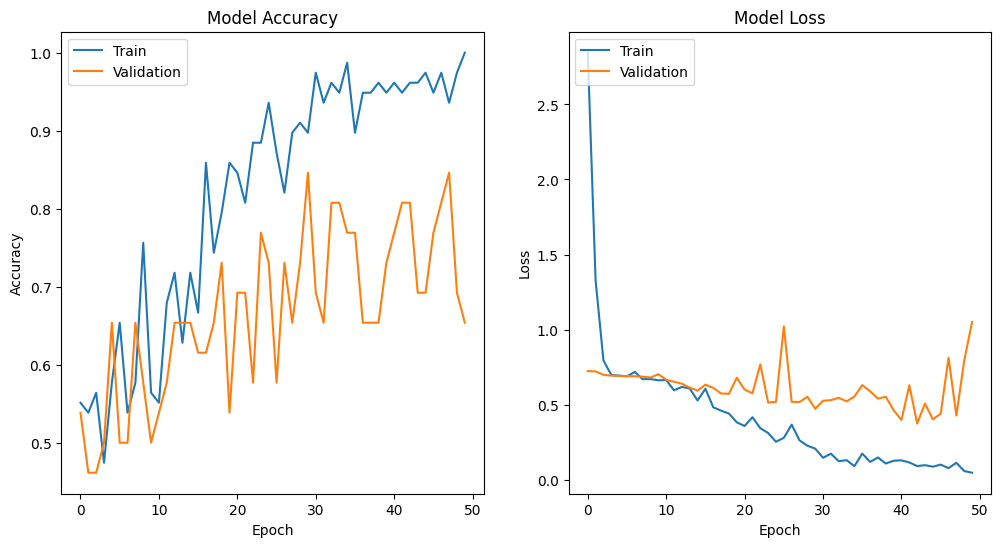

In [12]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")
plt.show()

1/1 [==============================] - 0s 251ms/step


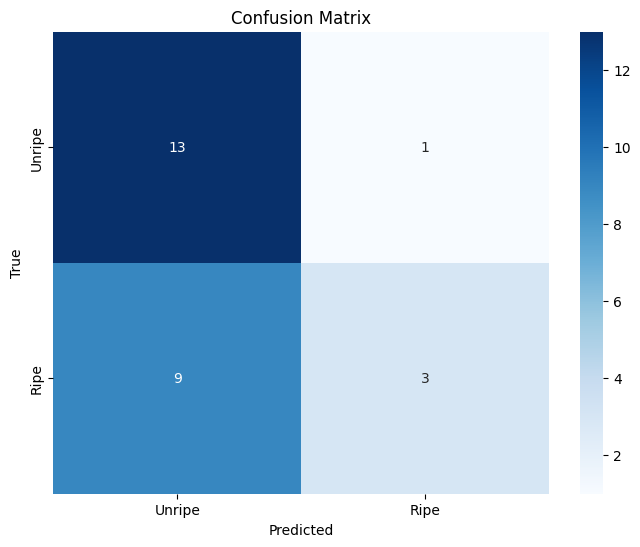

In [13]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# save model to .keras file
now = datetime.datetime.now()
# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")
oke = date_time_str
# model.save(f"{oke}.keras")